##Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.under_sampling import RandomUnderSampler



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


##Data Ingestion


In [2]:
# Load the dataset
data = pd.read_csv('3-Year_Recidivism_for_Offenders_Released_from_Prison_in_Iowa_elaborated.csv')

##Data Cleaning

In [ ]:
# Display first few rows
data.head()

,Fiscal Year Released,Recidivism Reporting Year,Race - Ethnicity,Age At Release,Convicting Offense Classification,Convicting Offense Type,Convicting Offense Subtype,Main Supervising District,Release Type,Release type: Paroled to Detainder united,Part of Target Population,Recidivism - Return to Prison numeric
0,2010,2013,White - Non-Hispanic,Under 25,D Felony,Violent,Assault,4JD,Parole,Parole,Yes,1
1,2010,2013,White - Non-Hispanic,55 and Older,D Felony,Public Order,OWI,7JD,Parole,Parole,Yes,1
2,2010,2013,White - Non-Hispanic,25-34,D Felony,Property,Burglary,5JD,Parole,Parole,Yes,1
3,2010,2013,White - Non-Hispanic,55 and Older,C Felony,Drug,Trafficking,8JD,Parole,Parole,Yes,1
4,2010,2013,Black - Non-Hispanic,25-34,D Felony,Drug,Trafficking,3JD,Parole,Parole,Yes,1


In [1]:
# Get variable information
data.info()

NameError: name 'data' is not defined

In [5]:
# Check for missing values in each column
missing_values = data.isnull().sum()

# Display count of missing values per column
print(missing_values)

Fiscal Year Released                            0
Recidivism Reporting Year                       0
Race - Ethnicity                               30
Age At Release                                  3
Convicting Offense Classification               0
Convicting Offense Type                         0
Convicting Offense Subtype                      0
Main Supervising District                    9581
Release Type                                 1762
Release type: Paroled to Detainder united    1762
Part of Target Population                       0
Recidivism - Return to Prison numeric           0
dtype: int64


In [3]:
# Remove rows with missing values in 'Race - Ethnicity' and 'Age At Release'
data = data.dropna(subset=['Race - Ethnicity', 'Age At Release '])

In [4]:
# Impute missing values in 'Main Supervising District', 'Release Type', and 'Release type: Paroled to Detainder united' with a new category 'Unknown'
data['Main Supervising District'].fillna('Unknown', inplace=True)
data['Release Type'].fillna('Unknown', inplace=True)
data['Release type: Paroled to Detainder united'].fillna('Unknown', inplace=True)

##Data Exploration

In [ ]:
# Count of obs. per offense subtype
data['Convicting Offense Subtype'].value_counts()


,count
Convicting Offense Subtype,
Trafficking,6486
Assault,3182
Burglary,2963
Theft,2676
OWI,1789
Sex,1276
Forgery/Fraud,1208
Other Criminal,1191
Drug Possession,1142


In [ ]:
# Count of obs. per ethnicity
data['Race - Ethnicity'].value_counts()


,count
Race - Ethnicity,
White - Non-Hispanic,17584
Black - Non-Hispanic,6109
White - Hispanic,1522
American Indian or Alaska Native - Non-Hispanic,502
Asian or Pacific Islander - Non-Hispanic,192
Black - Hispanic,37
American Indian or Alaska Native - Hispanic,20
White -,12
Asian or Pacific Islander - Hispanic,5


In [9]:
# #Count of obs. & percentage of Recidivist indivuals vs. Non recidists
rdv_value_counts = data['Recidivism - Return to Prison numeric'].value_counts()
rdv_percentages = data['Recidivism - Return to Prison numeric'].value_counts(normalize=True) * 100

rdv_result = pd.DataFrame({'Count': rdv_value_counts, 'Percentage': rdv_percentages})

print(rdv_result)

                                       Count  Percentage
Recidivism - Return to Prison numeric                   
0                                      17306   66.594836
1                                       8681   33.405164


<ipython-input-14-17a3fad70d47>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Recidivism - Return to Prison numeric', palette='pastel')


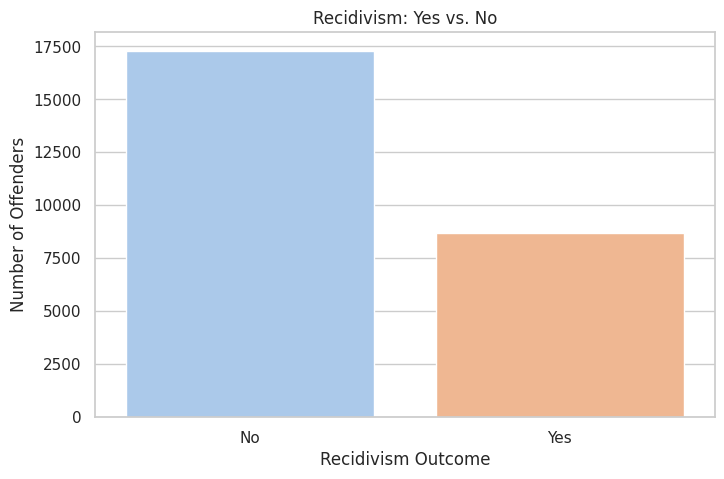

In [ ]:
# Plot of distribution of 'Recidivism - Return to Prison numeric'
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Recidivism - Return to Prison numeric', palette='pastel')
plt.title('Recidivism: Yes vs. No')
plt.xlabel('Recidivism Outcome')
plt.ylabel('Number of Offenders')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

<ipython-input-18-9f65254c110d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='pastel', order=data[column].value_counts().index)


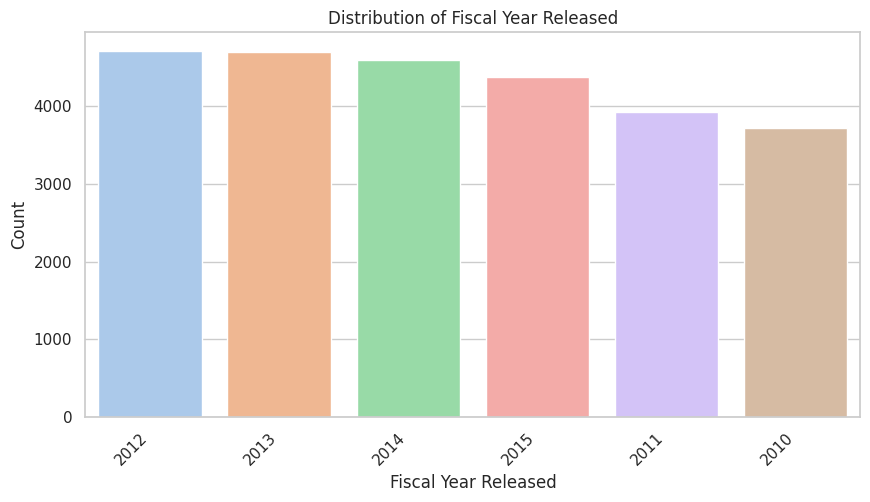

<ipython-input-18-9f65254c110d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='pastel', order=data[column].value_counts().index)


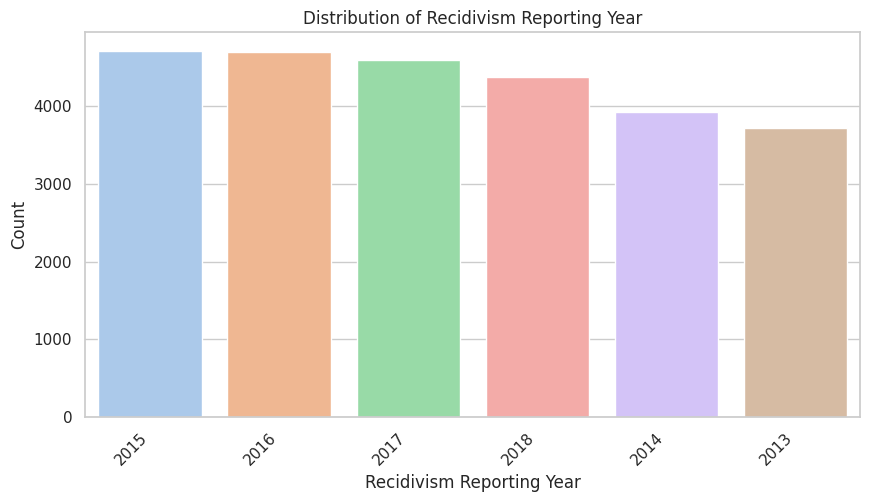

<ipython-input-18-9f65254c110d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='pastel', order=data[column].value_counts().index)


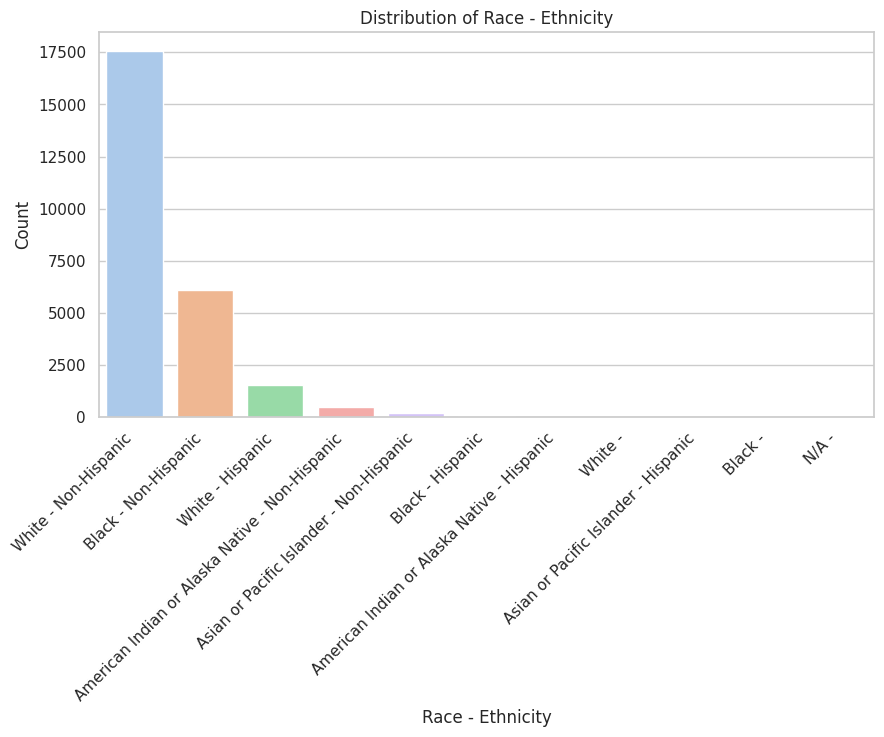

<ipython-input-18-9f65254c110d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='pastel', order=data[column].value_counts().index)


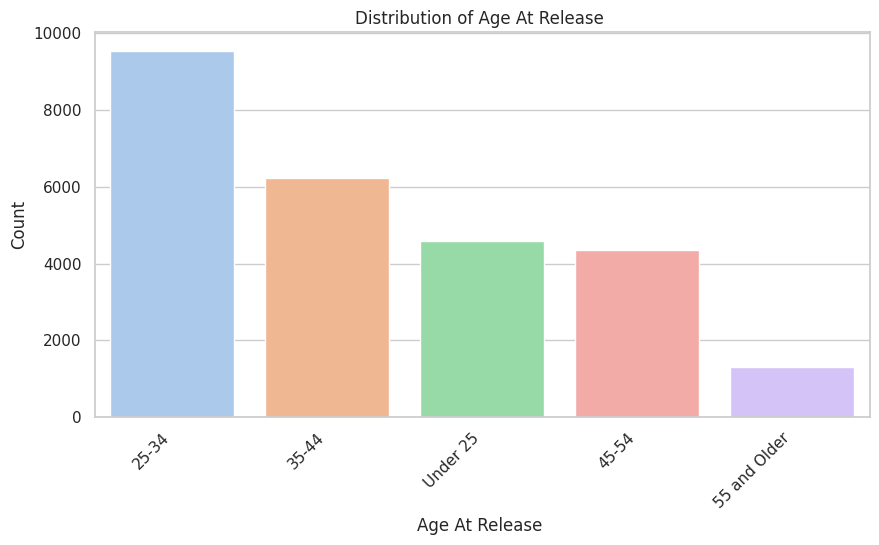

<ipython-input-18-9f65254c110d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='pastel', order=data[column].value_counts().index)


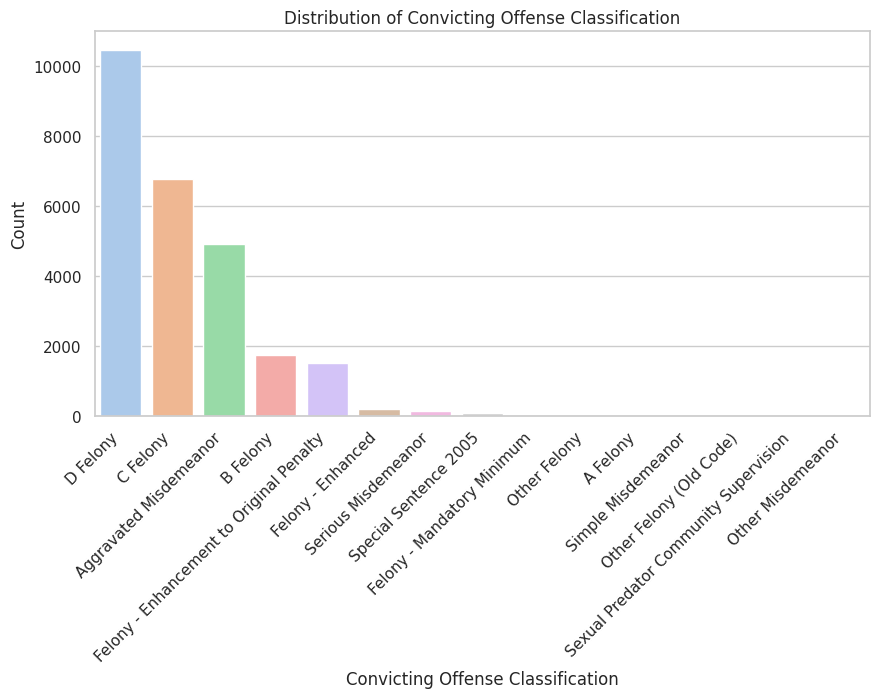

<ipython-input-18-9f65254c110d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='pastel', order=data[column].value_counts().index)


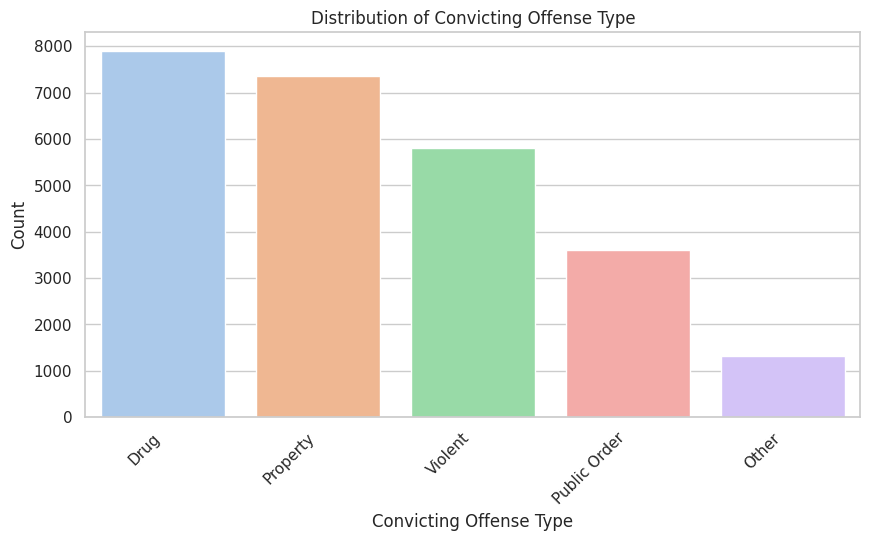

<ipython-input-18-9f65254c110d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='pastel', order=data[column].value_counts().index)


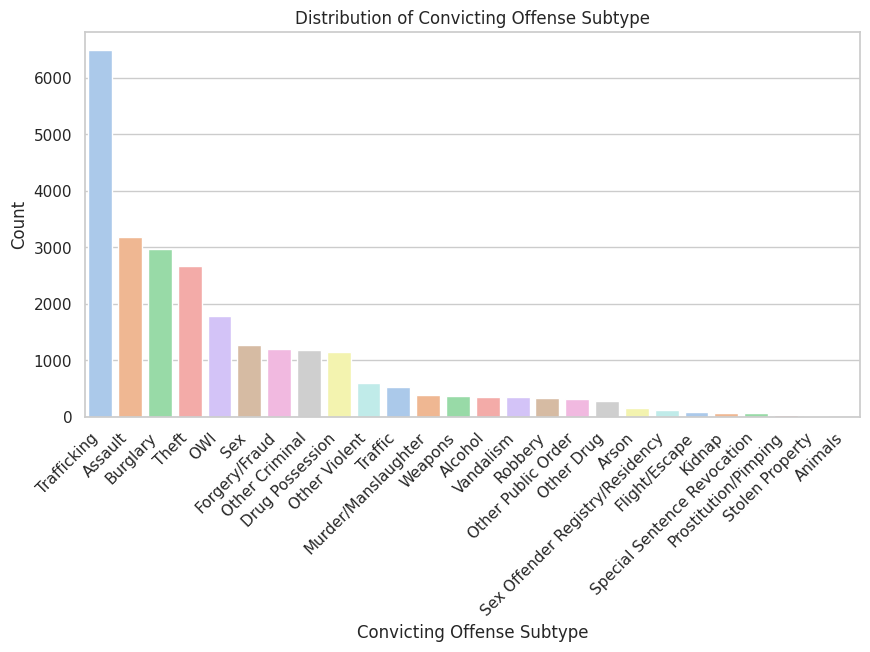

<ipython-input-18-9f65254c110d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='pastel', order=data[column].value_counts().index)


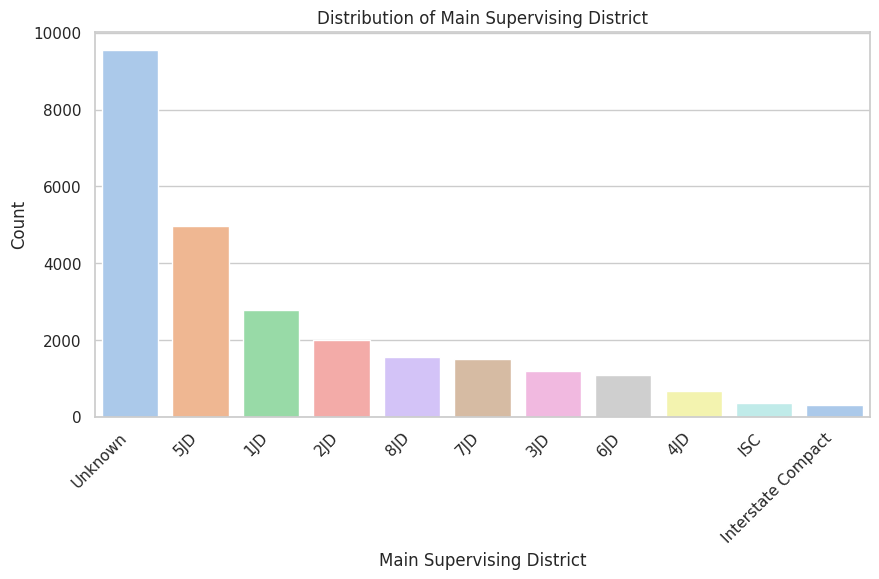

<ipython-input-18-9f65254c110d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='pastel', order=data[column].value_counts().index)


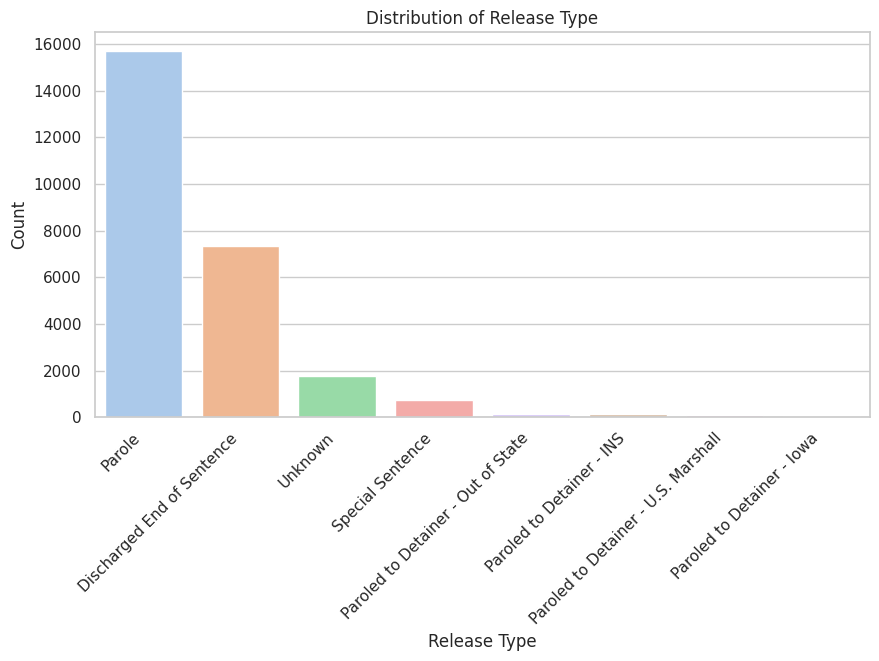

<ipython-input-18-9f65254c110d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='pastel', order=data[column].value_counts().index)


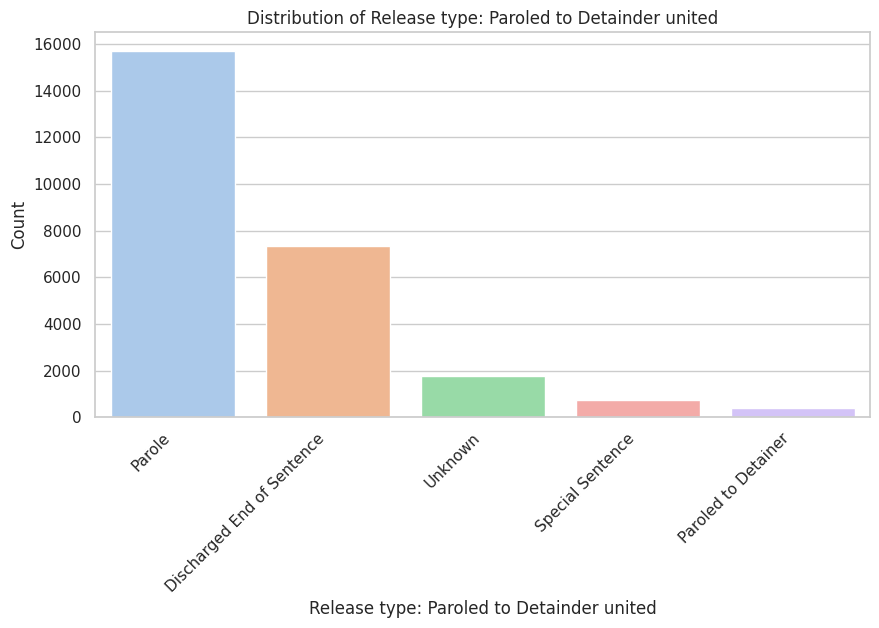

<ipython-input-18-9f65254c110d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='pastel', order=data[column].value_counts().index)


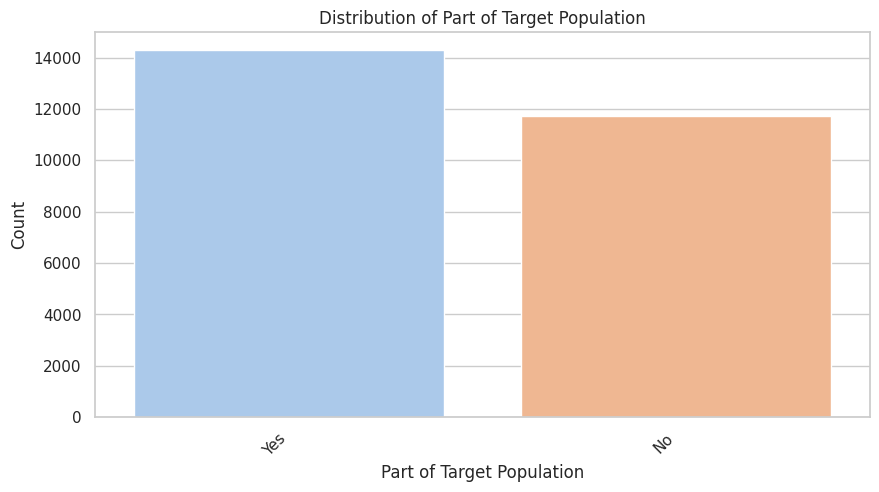

<ipython-input-18-9f65254c110d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='pastel', order=data[column].value_counts().index)


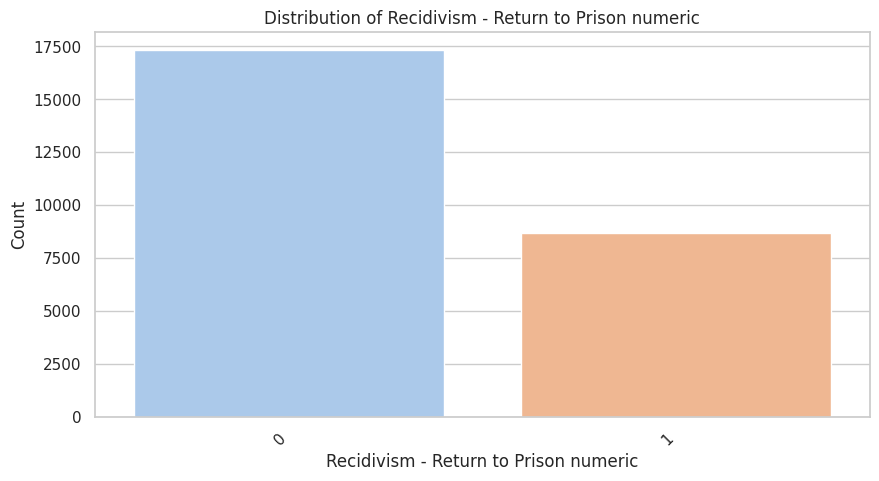

In [ ]:
## Dsitribution plots of other variables
categorical_columns = [
    'Fiscal Year Released',
    'Recidivism Reporting Year',
    'Age At Release ',
    'Convicting Offense Classification',
    'Convicting Offense Type',
    'Convicting Offense Subtype',
    'Main Supervising District',
    'Release Type',
    'Release type: Paroled to Detainder united',
    'Part of Target Population',
    'Recidivism - Return to Prison numeric'
]

sns.set(style="whitegrid")

for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=data, x=column, palette='pastel', order=data[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

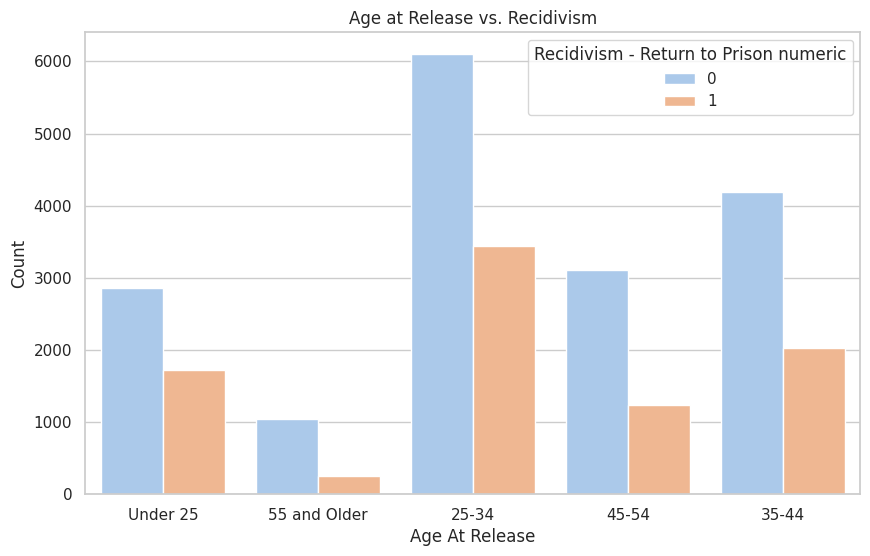

In [ ]:
# Age vs. Recidivism plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Age At Release ', hue='Recidivism - Return to Prison numeric', data=data, palette='pastel')
plt.title('Age at Release vs. Recidivism')
plt.xlabel('Age At Release')
plt.ylabel('Count')
plt.show()


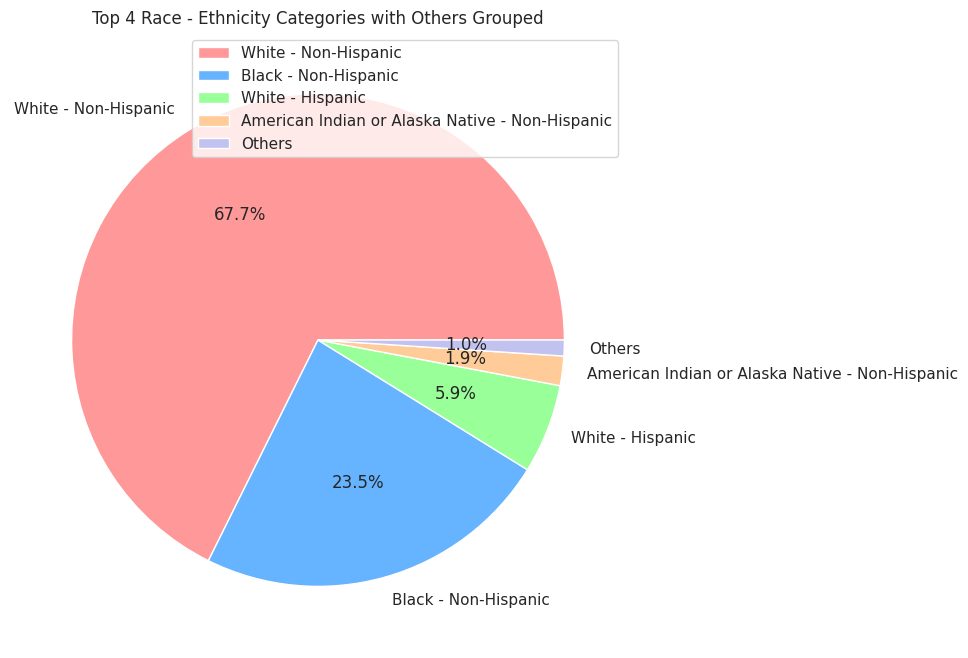

In [ ]:
# Distribution of Ethnicity Pie chart
race_counts = data['Race - Ethnicity'].value_counts()

top_4 = race_counts.nlargest(4)
others = race_counts.iloc[4:].sum()
top_4['Others'] = others

top_4.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.title('Top 4 Race - Ethnicity Categories with Others Grouped')
plt.ylabel('')

plt.legend(loc="best")
plt.show()

##Model Planning

In [5]:
# Define features and target
features = data.drop('Recidivism - Return to Prison numeric', axis=1)
target = data['Recidivism - Return to Prison numeric']


# Standardising and processing values
number_attributes = ["Fiscal Year Released", "Recidivism Reporting Year"]
text_attributes = [
    "Convicting Offense Classification",
    "Convicting Offense Type",
    "Convicting Offense Subtype",
    "Part of Target Population",
    "Age At Release ",
    "Race - Ethnicity",
    "Release Type",
    "Release type: Paroled to Detainder united",
    "Main Supervising District"
]

pipeline = ColumnTransformer([
    ("numeric", StandardScaler(), number_attributes),
    ("text", OneHotEncoder(), text_attributes)
])

processed_data = pipeline.fit_transform(features)

print(processed_data.shape)
print(processed_data[:5])



(25987, 90)
  (0, 0)	-1.5653843719836136
  (0, 1)	-1.5653843719836136
  (0, 6)	1.0
  (0, 21)	1.0
  (0, 25)	1.0
  (0, 49)	1.0
  (0, 54)	1.0
  (0, 65)	1.0
  (0, 67)	1.0
  (0, 75)	1.0
  (0, 82)	1.0
  (1, 0)	-1.5653843719836136
  (1, 1)	-1.5653843719836136
  (1, 6)	1.0
  (1, 20)	1.0
  (1, 32)	1.0
  (1, 49)	1.0
  (1, 53)	1.0
  (1, 65)	1.0
  (1, 67)	1.0
  (1, 75)	1.0
  (1, 85)	1.0
  (2, 0)	-1.5653843719836136
  (2, 1)	-1.5653843719836136
  (2, 6)	1.0
  :	:
  (2, 67)	1.0
  (2, 75)	1.0
  (2, 83)	1.0
  (3, 0)	-1.5653843719836136
  (3, 1)	-1.5653843719836136
  (3, 5)	1.0
  (3, 17)	1.0
  (3, 45)	1.0
  (3, 49)	1.0
  (3, 53)	1.0
  (3, 65)	1.0
  (3, 67)	1.0
  (3, 75)	1.0
  (3, 86)	1.0
  (4, 0)	-1.5653843719836136
  (4, 1)	-1.5653843719836136
  (4, 6)	1.0
  (4, 17)	1.0
  (4, 45)	1.0
  (4, 49)	1.0
  (4, 50)	1.0
  (4, 61)	1.0
  (4, 67)	1.0
  (4, 75)	1.0
  (4, 81)	1.0


In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(processed_data, target, test_size=0.3, random_state=42)

In [14]:
print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Testing set shape: {X_test.shape}, {y_test.shape}')

Training set shape: (18190, 90), (18190,)
Testing set shape: (7797, 90), (7797,)


In [7]:
# Apply RandomUnderSampler to create balanced dataset
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


In [8]:
original_distribution = np.bincount(y_train)
undersampled_distribution = np.bincount(y_resampled)

print("Original class distribution:", original_distribution)
print("Undersampled class distribution:", undersampled_distribution)

Original class distribution: [12094  6096]
Undersampled class distribution: [6096 6096]


##Model Building

### Logistic Regression

#### Original dataset


In [17]:
# Logistic regression on original dataset
model_original = LogisticRegression(max_iter=1000)
model_original.fit(X_train, y_train)
y_pred_original = model_original.predict(X_test)
print("Logistic Regression on Original Data")
print(accuracy_score(y_test, y_pred_original))
print(classification_report(y_test, y_pred_original))

Logistic Regression on Original Data
0.6769270232140567
              precision    recall  f1-score   support

           0       0.69      0.93      0.79      5212
           1       0.54      0.17      0.26      2585

    accuracy                           0.68      7797
   macro avg       0.62      0.55      0.53      7797
weighted avg       0.64      0.68      0.62      7797



#### Undersampled Dataset


In [18]:
# Logistic regression on undersampled dataset
model_undersampled = LogisticRegression(max_iter=1000)
model_undersampled.fit(X_resampled, y_resampled)
y_pred_undersampled = model_undersampled.predict(X_test)
print("Logistic Regression on Undersampled Data")
print(accuracy_score(y_test, y_pred_undersampled))
print(classification_report(y_test, y_pred_undersampled))

Logistic Regression on Undersampled Data
0.5999743491086316
              precision    recall  f1-score   support

           0       0.78      0.56      0.65      5212
           1       0.43      0.68      0.53      2585

    accuracy                           0.60      7797
   macro avg       0.61      0.62      0.59      7797
weighted avg       0.66      0.60      0.61      7797



### Random Forest


#### Original dataset


In [19]:
# Random Forest on original dataset
rf_original = RandomForestClassifier(random_state=42)
rf_original.fit(X_train, y_train)
y_pred_rf_original = rf_original.predict(X_test)

print("Random Forest on Original Data")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_original))
print(classification_report(y_test, y_pred_rf_original))

rf_original_conf_matrix = confusion_matrix(y_test, y_pred_rf_original)
print("Confusion Matrix:")
print(rf_original_conf_matrix)

Random Forest on Original Data
Accuracy: 0.6512761318455816
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      5212
           1       0.47      0.35      0.40      2585

    accuracy                           0.65      7797
   macro avg       0.59      0.57      0.58      7797
weighted avg       0.63      0.65      0.64      7797

Confusion Matrix:
[[4179 1033]
 [1686  899]]


#### Undersampled dataset

In [20]:
# Random Forest on undersampled dataset
rf_undersampled = RandomForestClassifier(random_state=42)
rf_undersampled.fit(X_resampled, y_resampled)
y_pred_rf_undersampled = rf_undersampled.predict(X_test)

print("Random Forest on Undersampled Data")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_undersampled))
print(classification_report(y_test, y_pred_rf_undersampled))

rf_undersampled_conf_matrix = confusion_matrix(y_test, y_pred_rf_undersampled)
print("Confusion Matrix:")
print(rf_undersampled_conf_matrix)

Random Forest on Undersampled Data
Accuracy: 0.5904835193022957
              precision    recall  f1-score   support

           0       0.75      0.57      0.65      5212
           1       0.42      0.62      0.50      2585

    accuracy                           0.59      7797
   macro avg       0.59      0.60      0.58      7797
weighted avg       0.64      0.59      0.60      7797

Confusion Matrix:
[[2995 2217]
 [ 976 1609]]


### Gradient Boosting


#### Original dataset

In [21]:
# Gradient Boosting on original dataset
gb_original = GradientBoostingClassifier(random_state=42)
gb_original.fit(X_train, y_train)
y_pred_gb_original = gb_original.predict(X_test)

print("Gradient Boosting on Original Data")
print("Accuracy:", accuracy_score(y_test, y_pred_gb_original))
print(classification_report(y_test, y_pred_gb_original))

gb_original_conf_matrix = confusion_matrix(y_test, y_pred_gb_original)
print("Confusion Matrix:")
print(gb_original_conf_matrix)

Gradient Boosting on Original Data
Accuracy: 0.6819289470309093
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      5212
           1       0.58      0.14      0.23      2585

    accuracy                           0.68      7797
   macro avg       0.64      0.55      0.52      7797
weighted avg       0.65      0.68      0.61      7797

Confusion Matrix:
[[4944  268]
 [2212  373]]


#### Undersampled dataset

In [22]:
# Gradient Boosting on undersampled dataset
gb_undersampled = GradientBoostingClassifier(random_state=42)
gb_undersampled.fit(X_resampled, y_resampled)
y_pred_gb_undersampled = gb_undersampled.predict(X_test)

print("Gradient Boosting on Undersampled Data")
print("Accuracy:", accuracy_score(y_test, y_pred_gb_undersampled))
print(classification_report(y_test, y_pred_gb_undersampled))

gb_undersampled_conf_matrix = confusion_matrix(y_test, y_pred_gb_undersampled)
print("Confusion Matrix:")
print(gb_undersampled_conf_matrix)

Gradient Boosting on Undersampled Data
Accuracy: 0.6051045273823266
              precision    recall  f1-score   support

           0       0.79      0.56      0.66      5212
           1       0.44      0.69      0.54      2585

    accuracy                           0.61      7797
   macro avg       0.61      0.63      0.60      7797
weighted avg       0.67      0.61      0.62      7797

Confusion Matrix:
[[2934 2278]
 [ 801 1784]]


### Light GBM


#### Original Dataset

In [23]:
# LightGBM on original dataset
lgb_original = lgb.LGBMClassifier(random_state=42)
lgb_original.fit(X_train, y_train)
y_pred_lgb_original = lgb_original.predict(X_test)

print("LightGBM on Original Data")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb_original))
print(classification_report(y_test, y_pred_lgb_original))

lgb_original_conf_matrix = confusion_matrix(y_test, y_pred_lgb_original)
print("Confusion Matrix:")
print(lgb_original_conf_matrix)

[LightGBM] [Info] Number of positive: 6096, number of negative: 12094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 18190, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335129 -> initscore=-0.685077
[LightGBM] [Info] Start training from score -0.685077
LightGBM on Original Data
Accuracy: 0.6855200718224959
              precision    recall  f1-score   support

           0       0.71      0.91      0.79      5212
           1       0.56      0.24      0.33      2585

    accuracy                           0.69      7797
   macro avg       0.63      0.57      0.56      7797
weighted avg       0.66      0.69      0.64      7797

Confusion Matrix:
[[4729  483]
 [1969  616]]


#### Undersampled dataset

In [24]:
# LightGBM on undersampled dataset
lgb_undersampled = lgb.LGBMClassifier(random_state=42)
lgb_undersampled.fit(X_resampled, y_resampled)
y_pred_lgb_undersampled = lgb_undersampled.predict(X_test)

print("LightGBM on Undersampled Data")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb_undersampled))
print(classification_report(y_test, y_pred_lgb_undersampled))

lgb_undersampled_conf_matrix = confusion_matrix(y_test, y_pred_lgb_undersampled)
print("Confusion Matrix:")
print(lgb_undersampled_conf_matrix)

[LightGBM] [Info] Number of positive: 6096, number of negative: 6096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 158
[LightGBM] [Info] Number of data points in the train set: 12192, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM on Undersampled Data
Accuracy: 0.6102347056560216
              precision    recall  f1-score   support

           0       0.78      0.58      0.67      5212
           1       0.44      0.67      0.53      2585

    accuracy                           0.61      7797
   macro avg       0.61      0.63      0.60      7797
weighted avg       0.67      0.61      0.62      7797

Confusion Matrix:
[[3018 2194]
 [ 845 1740]]


### Ensemble methods

#### Stacking

In [25]:
# Define base models
base_estimators = [
    ('rf_clf', RandomForestClassifier(random_state=42)),
    ('gb_clf', GradientBoostingClassifier(random_state=42)),
    ('lgb_clf', lgb.LGBMClassifier(random_state=42))
]

meta_model = LogisticRegression(max_iter=1000)

stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=meta_model)


##### Original dataset


In [26]:
# Stacking on Original Dataset
stacking_clf.fit(X_train, y_train)
y_pred_stacking_original = stacking_clf.predict(X_test)

print("Stacking Classifier on Original Data")
print("Accuracy:", accuracy_score(y_test, y_pred_stacking_original))
print(classification_report(y_test, y_pred_stacking_original))

stacking_original_conf_matrix = confusion_matrix(y_test, y_pred_stacking_original)
print("Confusion Matrix:")
print(stacking_original_conf_matrix)

[LightGBM] [Info] Number of positive: 6096, number of negative: 12094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 18190, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335129 -> initscore=-0.685077
[LightGBM] [Info] Start training from score -0.685077
[LightGBM] [Info] Number of positive: 4876, number of negative: 9676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 158
[LightGBM] [Info] Number of data points in the train set: 14552, number of used features: 74
[LightGBM] [Info] [bina

##### Undersampled dataset

In [27]:
# Stacking on Undersampled Dataset
stacking_clf.fit(X_resampled, y_resampled)
y_pred_stacking_undersampled = stacking_clf.predict(X_test)

print("Stacking Classifier on Undersampled Data")
print("Accuracy:", accuracy_score(y_test, y_pred_stacking_undersampled))
print(classification_report(y_test, y_pred_stacking_undersampled))

stacking_undersampled_conf_matrix = confusion_matrix(y_test, y_pred_stacking_undersampled)
print("Confusion Matrix:")
print(stacking_undersampled_conf_matrix)

[LightGBM] [Info] Number of positive: 6096, number of negative: 6096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 158
[LightGBM] [Info] Number of data points in the train set: 12192, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4877, number of negative: 4876
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 158
[LightGBM] [Info] Number of data points in the train set: 9753, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500051 -> initscore=0.000205
[

#### Bagging

##### Original dataset

In [28]:
# Bagging with Decision Trees on original dataset
bagging_clf_original = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=42, oob_score=True)
bagging_clf_original.fit(X_train, y_train)
y_pred_bagging_original = bagging_clf_original.predict(X_test)

print("Bagging Classifier on Original Data")
print("Accuracy:", accuracy_score(y_test, y_pred_bagging_original))
print(classification_report(y_test, y_pred_bagging_original))

bagging_original_conf_matrix = confusion_matrix(y_test, y_pred_bagging_original)
print("Confusion Matrix:")
print(bagging_original_conf_matrix)


Bagging Classifier on Original Data
Accuracy: 0.6437091188918815
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      5212
           1       0.45      0.37      0.40      2585

    accuracy                           0.64      7797
   macro avg       0.58      0.57      0.58      7797
weighted avg       0.63      0.64      0.63      7797

Confusion Matrix:
[[4074 1138]
 [1640  945]]


##### Undersampled dataset

In [29]:
# Bagging with Decision Trees on undersampled dataset
bagging_clf_undersampled = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=42, oob_score=True)
bagging_clf_undersampled.fit(X_resampled, y_resampled)
y_pred_bagging_undersampled = bagging_clf_undersampled.predict(X_test)

print("Bagging Classifier on Undersampled Data")
print("Accuracy:", accuracy_score(y_test, y_pred_bagging_undersampled))
print(classification_report(y_test, y_pred_bagging_undersampled))

bagging_undersampled_conf_matrix = confusion_matrix(y_test, y_pred_bagging_undersampled)
print("Confusion Matrix:")
print(bagging_undersampled_conf_matrix)

Bagging Classifier on Undersampled Data
Accuracy: 0.5829165063485956
              precision    recall  f1-score   support

           0       0.75      0.57      0.65      5212
           1       0.41      0.61      0.49      2585

    accuracy                           0.58      7797
   macro avg       0.58      0.59      0.57      7797
weighted avg       0.64      0.58      0.60      7797

Confusion Matrix:
[[2959 2253]
 [ 999 1586]]


### SVM

#### Original dataset

In [30]:
# SVM on original dataset
svm_original = SVC(kernel='rbf', random_state=42)
svm_original.fit(X_train, y_train)
y_pred_svm_original = svm_original.predict(X_test)

print("SVM on Original Data")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_original))
print(classification_report(y_test, y_pred_svm_original))

svm_original_conf_matrix = confusion_matrix(y_test, y_pred_svm_original)
print("Confusion Matrix:")
print(svm_original_conf_matrix)

SVM on Original Data
Accuracy: 0.6860330896498653
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      5212
           1       0.60      0.16      0.25      2585

    accuracy                           0.69      7797
   macro avg       0.65      0.55      0.53      7797
weighted avg       0.66      0.69      0.62      7797

Confusion Matrix:
[[4931  281]
 [2167  418]]


#### Undersampled dataset

In [31]:
# SVM on undersampled dataset
svm_undersampled = SVC(kernel='rbf', random_state=42)
svm_undersampled.fit(X_resampled, y_resampled)
y_pred_svm_undersampled = svm_undersampled.predict(X_test)

print("SVM on Undersampled Data")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_undersampled))
print(classification_report(y_test, y_pred_svm_undersampled))

svm_undersampled_conf_matrix = confusion_matrix(y_test, y_pred_svm_undersampled)
print("Confusion Matrix:")
print(svm_undersampled_conf_matrix)

SVM on Undersampled Data
Accuracy: 0.6095934333718097
              precision    recall  f1-score   support

           0       0.78      0.57      0.66      5212
           1       0.44      0.68      0.54      2585

    accuracy                           0.61      7797
   macro avg       0.61      0.63      0.60      7797
weighted avg       0.67      0.61      0.62      7797

Confusion Matrix:
[[2992 2220]
 [ 824 1761]]


## Model Comparison

### Key Metrics and Confusion Matrices

In [33]:

# Comparing metrics for all models
model_results = {
    "Model": [],
    "Dataset": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

def collect_metrics(model_name, dataset_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    model_results["Model"].append(model_name)
    model_results["Dataset"].append(dataset_name)
    model_results["Accuracy"].append(accuracy)
    model_results["Precision"].append(precision)
    model_results["Recall"].append(recall)
    model_results["F1-Score"].append(f1)


# Logistic Regression
collect_metrics("Logistic Regression", "Original", y_test, y_pred_original)
collect_metrics("Logistic Regression", "Undersampled", y_test, y_pred_undersampled)

# Random Forest
collect_metrics("Random Forest", "Original", y_test, y_pred_rf_original)
collect_metrics("Random Forest", "Undersampled", y_test, y_pred_rf_undersampled)

# Gradient Boosting
collect_metrics("Gradient Boosting", "Original", y_test, y_pred_gb_original)
collect_metrics("Gradient Boosting", "Undersampled", y_test, y_pred_gb_undersampled)

# LightGBM
collect_metrics("LightGBM", "Original", y_test, y_pred_lgb_original)
collect_metrics("LightGBM", "Undersampled", y_test, y_pred_lgb_undersampled)

# Stacking
collect_metrics("Stacking", "Original", y_test, y_pred_stacking_original)
collect_metrics("Stacking", "Undersampled", y_test, y_pred_stacking_undersampled)

# Bagging
collect_metrics("Bagging", "Original", y_test, y_pred_bagging_original)
collect_metrics("Bagging", "Undersampled", y_test, y_pred_bagging_undersampled)

# SVM
collect_metrics("SVM", "Original", y_test, y_pred_svm_original)
collect_metrics("SVM", "Undersampled", y_test, y_pred_svm_undersampled)

results_df = pd.DataFrame(model_results)
print(results_df)

                  Model       Dataset  Accuracy  Precision    Recall  F1-Score
0   Logistic Regression      Original  0.676927   0.539952  0.172534  0.261507
1   Logistic Regression  Undersampled  0.599974   0.433780  0.676596  0.528638
2         Random Forest      Original  0.651276   0.465321  0.347776  0.398052
3         Random Forest  Undersampled  0.590484   0.420544  0.622437  0.501950
4     Gradient Boosting      Original  0.681929   0.581903  0.144294  0.231246
5     Gradient Boosting  Undersampled  0.605105   0.439193  0.690135  0.536784
6              LightGBM      Original  0.685520   0.560510  0.238298  0.334419
7              LightGBM  Undersampled  0.610235   0.442298  0.673114  0.533824
8              Stacking      Original  0.685135   0.562863  0.225145  0.321636
9              Stacking  Undersampled  0.613698   0.446045  0.682785  0.539590
10              Bagging      Original  0.643709   0.453673  0.365571  0.404884
11              Bagging  Undersampled  0.582917   0.

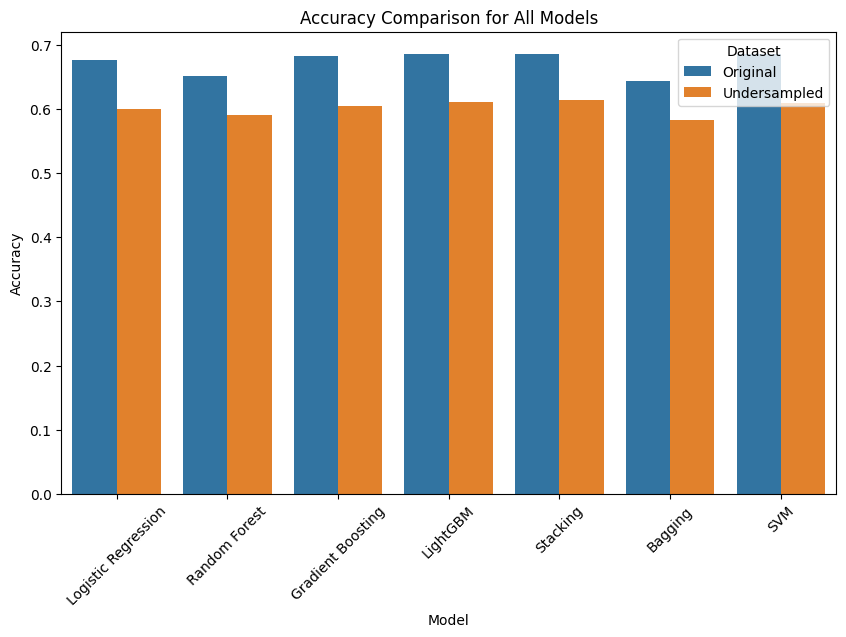

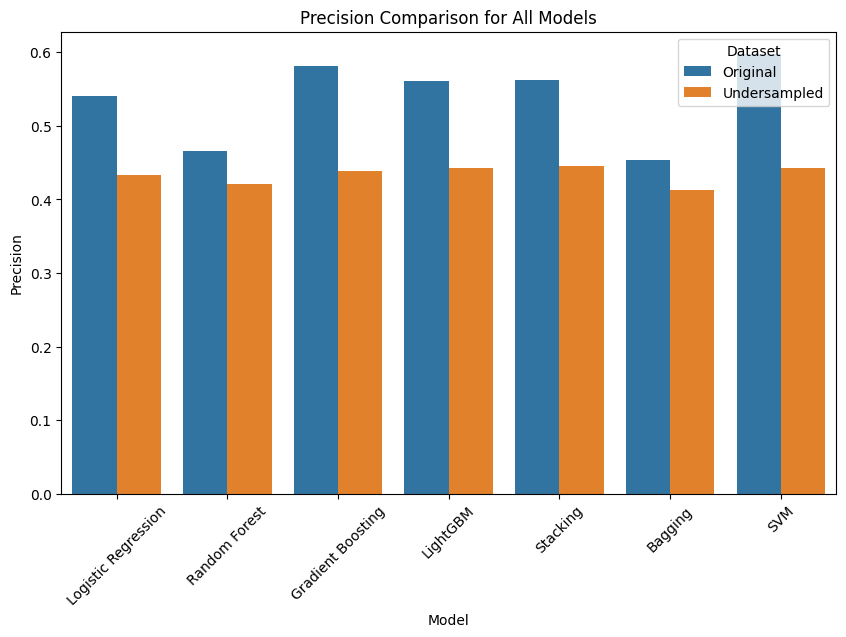

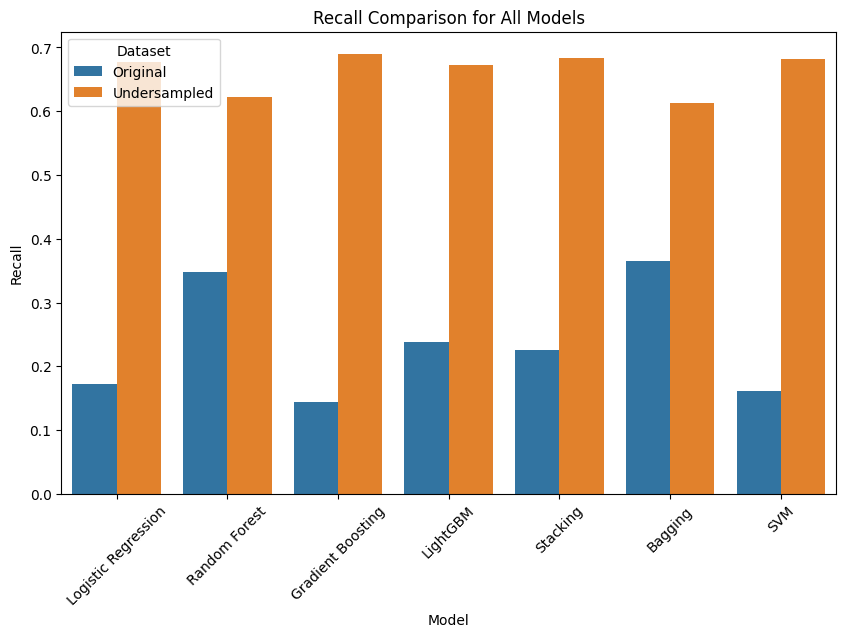

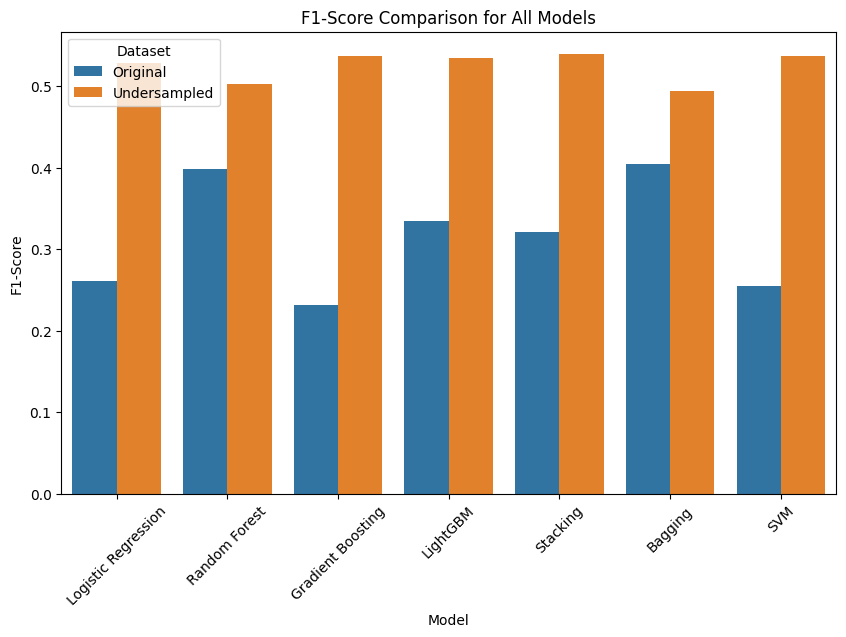

In [34]:
# Bar plots for Accuracy, Precision, Recall, and F1-Score
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Model", y=metric, hue="Dataset", data=results_df)
    plt.title(f"{metric} Comparison for All Models")
    plt.xticks(rotation=45)
    plt.show()

### Confusion Matrix

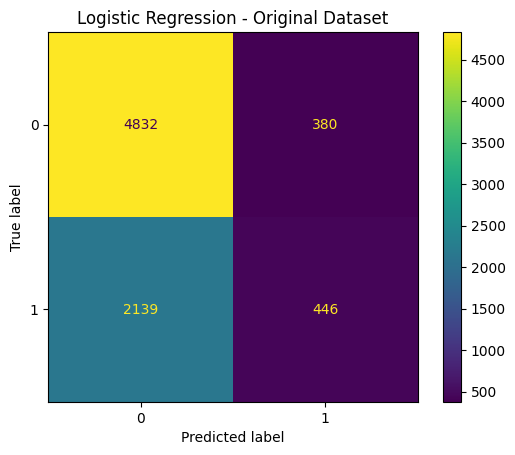

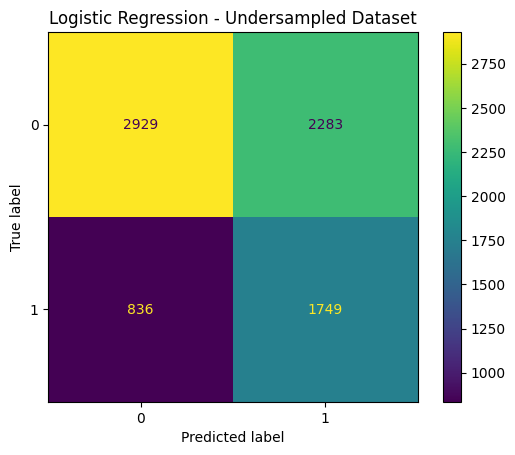

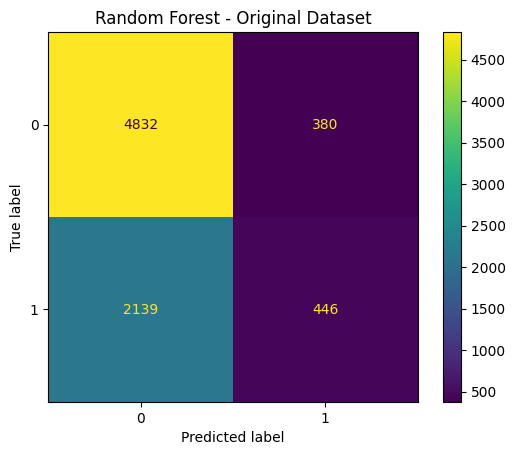

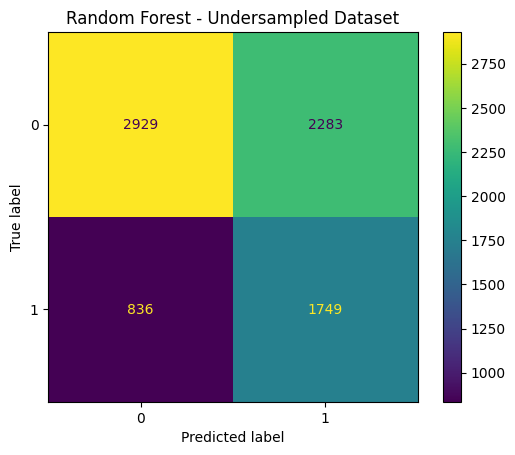

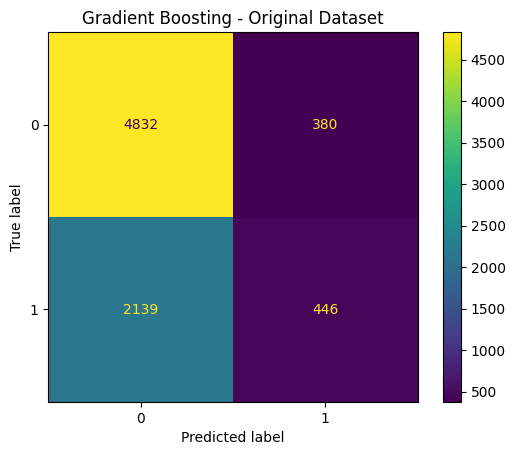

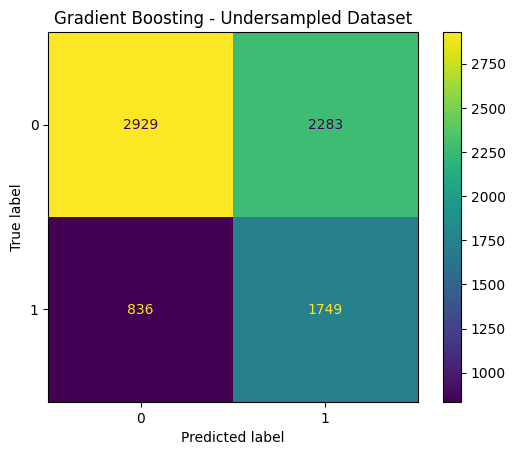

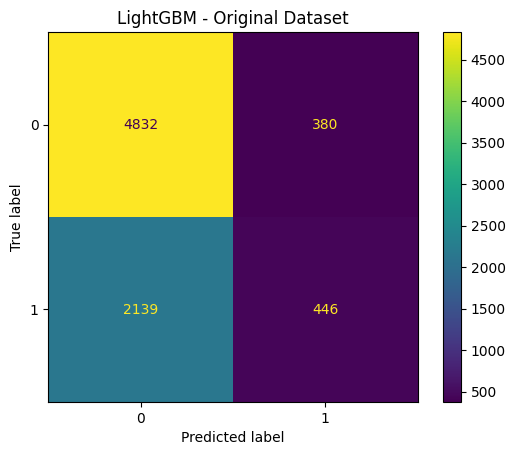

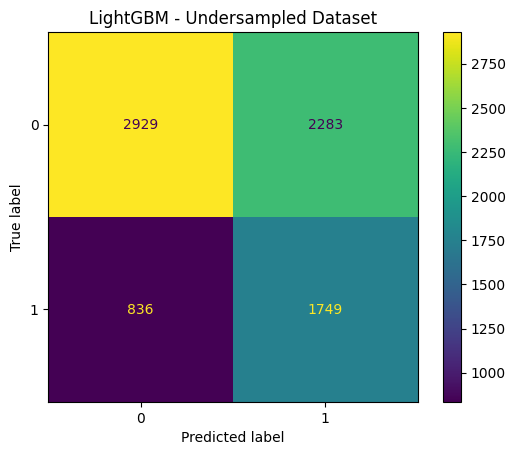

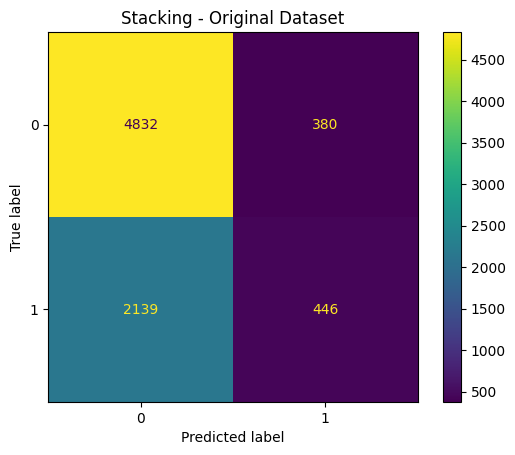

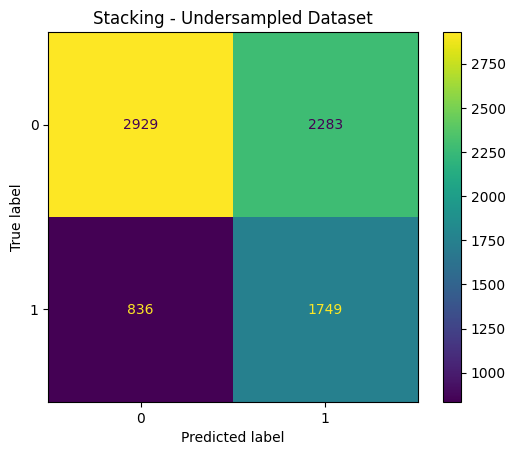

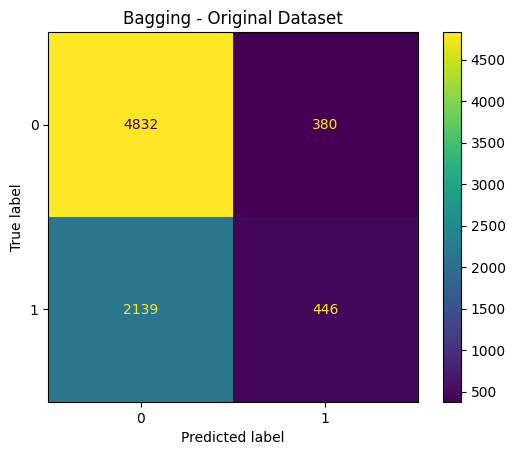

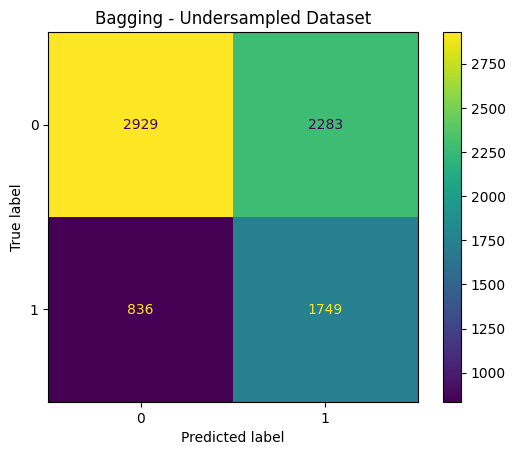

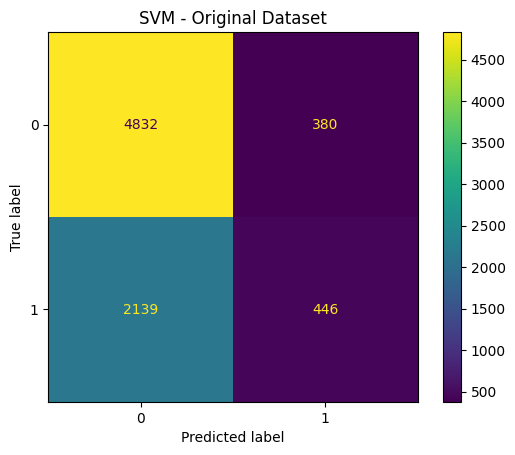

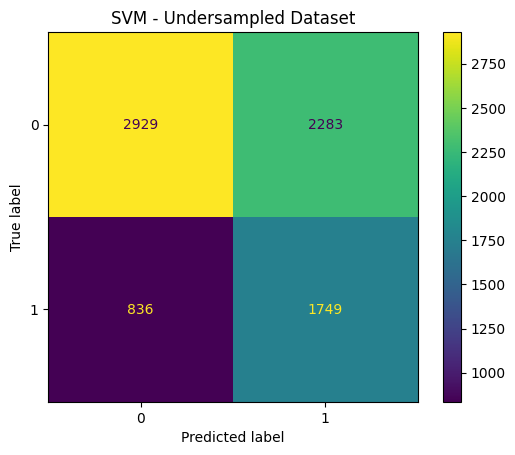

In [37]:
# Confusion matrix plots for all models
models = ["Logistic Regression", "Random Forest", "Gradient Boosting", "LightGBM", "Stacking", "Bagging", "SVM"]
conf_matrices = [
    (y_test, y_pred_original, "Original"),
    (y_test, y_pred_undersampled, "Undersampled")
]

for model in models:
    for y_true, y_pred, dataset_type in conf_matrices:
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
        plt.title(f"{model} - {dataset_type} Dataset")
        plt.show()

### AUC-ROC Curve Comparison

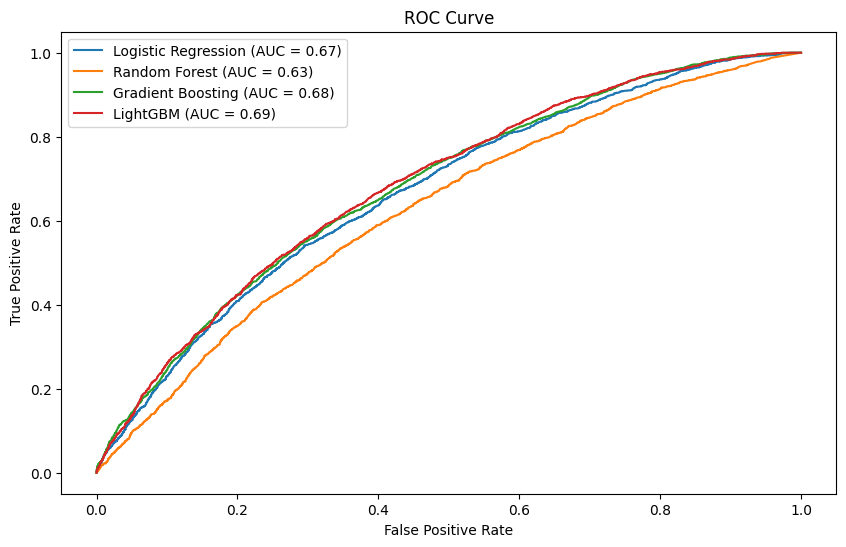

In [40]:
# Plot ROC curves for all models
def plot_roc_curve(model, X_test, y_test, model_name):
    y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

plt.figure(figsize=(10, 6))
plot_roc_curve(model_original, X_test, y_test, "Logistic Regression")
plot_roc_curve(rf_original, X_test, y_test, "Random Forest")
plot_roc_curve(gb_original, X_test, y_test, "Gradient Boosting")
plot_roc_curve(lgb_original, X_test, y_test, "LightGBM")
plt.show()


### Precision-Recall Curve

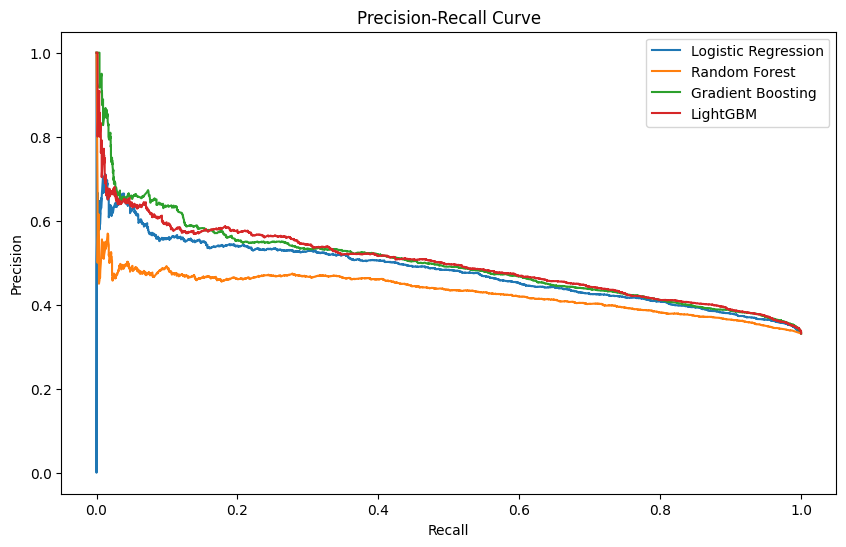

In [42]:
# Plot precision-recall curves
def plot_precision_recall_curve(model, X_test, y_test, model_name):
    y_pred_proba = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    plt.plot(recall, precision, label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()


plt.figure(figsize=(10, 6))
plot_precision_recall_curve(model_original, X_test, y_test, "Logistic Regression")
plot_precision_recall_curve(rf_original, X_test, y_test, "Random Forest")
plot_precision_recall_curve(gb_original, X_test, y_test, "Gradient Boosting")
plot_precision_recall_curve(lgb_original, X_test, y_test, "LightGBM")

plt.show()


### Feature importance

In [47]:
# Get feature names from the one-hot encoder
pipeline.fit(features)
numeric_feature_names = number_attributes

onehot_feature_names = pipeline.named_transformers_['text'].get_feature_names_out(text_attributes)

full_features_names = list(numeric_feature_names) + list(onehot_feature_names)

print(full_features_names)

['Fiscal Year Released', 'Recidivism Reporting Year', 'Convicting Offense Classification_A Felony', 'Convicting Offense Classification_Aggravated Misdemeanor', 'Convicting Offense Classification_B Felony', 'Convicting Offense Classification_C Felony', 'Convicting Offense Classification_D Felony', 'Convicting Offense Classification_Felony - Enhanced', 'Convicting Offense Classification_Felony - Enhancement to Original Penalty', 'Convicting Offense Classification_Felony - Mandatory Minimum', 'Convicting Offense Classification_Other Felony', 'Convicting Offense Classification_Other Felony (Old Code)', 'Convicting Offense Classification_Other Misdemeanor', 'Convicting Offense Classification_Serious Misdemeanor', 'Convicting Offense Classification_Sexual Predator Community Supervision', 'Convicting Offense Classification_Simple Misdemeanor', 'Convicting Offense Classification_Special Sentence 2005', 'Convicting Offense Type_Drug', 'Convicting Offense Type_Other', 'Convicting Offense Type_Pr

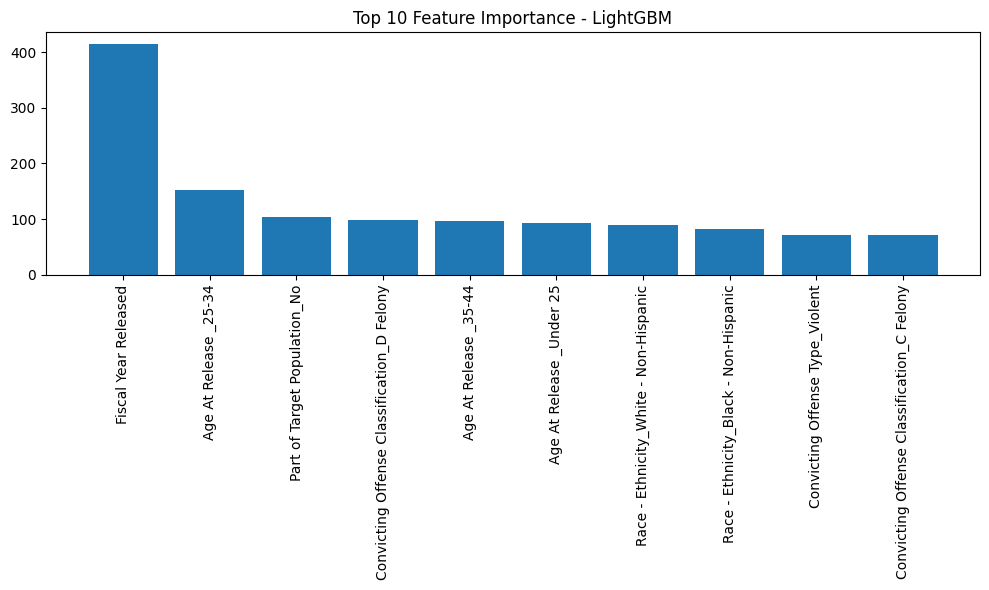

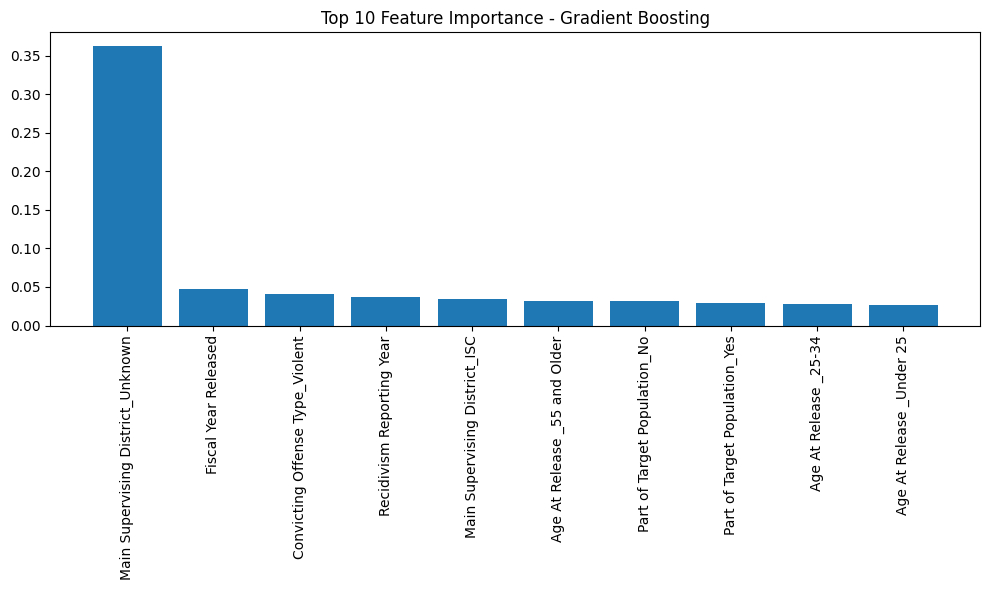

In [49]:
# Plot the top 10 most important features for models
def plot_top10_feature_importance(model, feature_names, model_name):
    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)[::-1]

    top10_indices = indices[:10]
    top10_feature_importances = feature_importances[top10_indices]
    top10_feature_names = [feature_names[i] for i in top10_indices]

    plt.figure(figsize=(10, 6))
    plt.title(f"Top 10 Feature Importance - {model_name}")
    plt.bar(range(10), top10_feature_importances, align="center")
    plt.xticks(range(10), top10_feature_names, rotation=90)
    plt.tight_layout()
    plt.show()

# Top 10 feature importance for LightGBM
plot_top10_feature_importance(lgb_original, full_features_names, "LightGBM")

# Top 10 feature importance for Gradient Boosting
plot_top10_feature_importance(gb_original, full_features_names, "Gradient Boosting")

## Model Tuning - Light GBM

In [52]:
# Model tuning with best parameters
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50, 70],
    'min_data_in_leaf': [20, 50, 100]
}

lgb_model = lgb.LGBMClassifier(random_state=42)

### Original dataset

In [53]:
# Grid Search for Original Dataset
grid_search_original = GridSearchCV(estimator=lgb_model, param_grid=param_grid,
                                    scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

grid_search_original.fit(X_train, y_train)

print("Best Hyperparameters for LightGBM on Original Data:", grid_search_original.best_params_)
print("Best Score (Original):", grid_search_original.best_score_)



Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 6096, number of negative: 12094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 18190, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335129 -> initscore=-0.685077
[LightGBM] [Info] Start training from score -0.685077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

### Undersampled dataset

In [54]:
# Grid Search for Undersampled Dataset
grid_search_undersampled = GridSearchCV(estimator=lgb_model, param_grid=param_grid,
                                        scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

grid_search_undersampled.fit(X_resampled, y_resampled)

print("Best Hyperparameters for LightGBM on Undersampled Data:", grid_search_undersampled.best_params_)
print("Best Score (Undersampled):", grid_search_undersampled.best_score_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 6096, number of negative: 6096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 12192, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

### Applying Parameters

#### Original dataset

In [55]:
# Best parameters for original dataset
best_lgb_params_original = {'learning_rate': 0.01, 'max_depth': 5, 'min_data_in_leaf': 20,
                        'n_estimators': 500, 'num_leaves': 50}

lgb_best_original = lgb.LGBMClassifier(**best_lgb_params_original, random_state=42)
lgb_best_original.fit(X_train, y_train)

y_pred_best_lgb_original = lgb_best_original.predict(X_test)
print("LightGBM Performance on Original Dataset")
print("Accuracy on Test Set (Original):", accuracy_score(y_test, y_pred_best_lgb_original))
print(classification_report(y_test, y_pred_best_lgb_original))



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 6096, number of negative: 12094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 18190, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335129 -> initscore=-0.685077
[LightGBM] [Info] Start training from score -0.685077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

#### Undersampled dataset

In [56]:
# Best parameters for undersampled dataset
best_lgb_params_undersampled = {'learning_rate': 0.05, 'max_depth': 3, 'min_data_in_leaf': 100,
                            'n_estimators': 500, 'num_leaves': 31}

lgb_best_undersampled = lgb.LGBMClassifier(**best_lgb_params_undersampled, random_state=42)
lgb_best_undersampled.fit(X_resampled, y_resampled)

y_pred_best_lgb_undersampled = lgb_best_undersampled.predict(X_test)
print("LightGBM Performance on Undersampled Dataset")
print("Accuracy on Test Set (Undersampled):", accuracy_score(y_test, y_pred_best_lgb_undersampled))
print(classification_report(y_test, y_pred_best_lgb_undersampled))

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 6096, number of negative: 6096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 12192, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur